<center>
<hr style='height:1px'>
<h1>Softwareprojekt SS2018</h1>
<h1>Kollektive Intelligenz in Autonomen Fahrzeugen</h1>
<h4>Team: Boyan Hristov, Adrian Herrmann, Luis Herrmann | Lecturer: Tim Landgraf</h4>
<hr style='height:1px'>
</center>

# Statistical Analysis

To determine how well our decentralized routing works, we created three different scenarios:

1. `NYSCrashAutonomousNoBeacon`: fully decentralized
2. `NYSCrash`: semi-centralized
3. `NYSCrashCentralized` fully decentralized

Our scenarios all follow a basic pattern: All cars share a specific route and are generated within a certain simulation time windows at certain time intervals. This setup creates a *flow* or *train* of vehicles travelling along the path specified.
In the base scenario, the cars will travel along their **initially fixed route** without any incidents. However, in all other scenarios, a *crazy* car will stop at a junction which lies on the path of the other cars, simulating an accident. This will cause the other cars to **detect the incident, calculate a new route and communicate the incident** detected to other simulation actors.

Scenarios 1. to 3. differ in how messages are spread in the system as a whole. In `NYSCrashAutonomousNoBeacon`, there are **no beacons and cars have a limited transmission range**. Thus, it is a fully decentralized scenario, where only autonomous communicate.

In `NYSCrash`, there is a beacon placed at a specific junction which acts as a repeater with limited transmission range (200 meters) an storage for messages sent by cars. The idea behind this concept was that, since the **range of car antennae** can be expected to be quite **limited**, **transporting messages over long ranges and** ensuring **message persistence** in the system for a prolonged time may prove to be **difficult**. However, at least in cities where there are many junctions and traffic lights, this problem could be easened by using the pre-existing infrastructure and upgrading traffic lights with beacons that can receive, store and repeat messages received by other traffic participants. It is thus semi-centralized in the sense that the behaviour of vehicles is still coordinated locally among *floating* instances (the vehicles), but the distribution of the messages is aided by central, fixed instances that extend vehicle range.

Finally, in `NYSCrashCentralized`, there is a beacon a placed at the same junction as in `NYSCrash`, but **both beacon and vehicles have infinite transmission range**. In this way, we simulate a scenario where the autonomous vehicles are all connected point-to-point to a **central server** which stores the messages sent by all cars in the simulated world, such that all vehicles have complete knowledge of the traffic simulation state at all times.

<table><tr>
<td style="background: white" width=50%>
    <img src="../../res/img/beacon.png" />
    <br>
    <center>Image 1: Beacon positioned at a junction in the SUMO GUI.</center>
</td>
<td style="background: white" width=50%>
    <img src="../../res/img/stopping.png" />
    <br>
    <center>Image 2: Halting vehicle (blue) causes autonomous vehicles to reroute.</center>
</td>
</tr></table>

During simulation, we log information about the vehicles and the messages sent. These are:

For `NYSCrash`, `NYSCrashAutonomousNoBeacon` and `NYSCrashCentralized`, we log the following routing-related data:
1. `id`: The vehicle id.
2. `start_time`: The time at which the vehicle with `id` entered the edge with `edge_id`.
3. `travel_time`: The time it took for vehicle with `id`to traverse the edge with `edge_id`.
4. `wait_time`: The time the vehilce with `id` spent waiting at the edge with `edge_id`.
5. `edge_id`: The edge id.
6. `reroute_count`: Number of reroutes performed by vehicle with `id` at the edge with `edge_id`.

For `NYSCrash` and `NYSCrashAutonomousNoBeacon` we log the following messaging-related data:
1. `simulation_time`: The current simulation time.
2. `peer_id`: The id of the communication peer (typically vehicle id).
3. `transmission_range`: The range of the message transmission.
4. `messages_sent`: The number of messages sent by `peer_id` at `simulation_time`.
5. `messages_received`: The number of messages received by `peer_id`at `simulation_time`.
6. `messages_distributing`: The number of message scheduled by `peer_id`for redistribution.

Since `NYSCrashCentralized` works a bit differently, we decided to log different messaing-related data, namely:
1. `time`: The current simulation time.
2. `to_server_count`: The number of messages sent to the server.
3. `from_server_count`: The number of messages dispatched by the server.
4. `total_count`: The total number of messages handled by the server.


We now proceed to import our data. First, we import the required libraries:

In [1]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sumolib import net
from astropy.convolution import Gaussian1DKernel, convolve
from IPython.core import display

fig_size = [20, 5]
plt.rcParams["figure.figsize"] = fig_size

Assuming there is already data for the scenarios in the directory, we import these into a dictionary for vehicle logs and one for message logs, respectively:

In [2]:
directory_out = "../../out/"
directory_scenario = "../../res/Scenarios/"
csv_file_list = [f for f in os.listdir(directory_out) 
             if os.path.isfile(os.path.join(directory_out, f))
             and f.endswith(".csv")
            ]

data_vehicles = {}
data_messages = {}
nets = {}

for f in csv_file_list:
    split_str = f.split("_")
    scenario = split_str[0]
    assert len(split_str) >= 1
    df = pd.read_csv(os.path.join(directory_out, f))
    if split_str[-2] == "vehicle":
        data_vehicles[scenario] = df
        nets[scenario] = net.readNet(os.path.join(directory_scenario + split_str[0], split_str[0] +'.net.xml'))
    elif split_str[-2] == "message":
        data_messages[scenario] = df
        
count_scenarios = len(data_vehicles)

We check that the input of all files is reasonable contains the data specified above:

In [3]:
for scenario in data_vehicles.keys():
    print("\n{0}: ".format(scenario))
    display.display(data_vehicles[scenario].head())
    display.display(data_messages[scenario].head())


NYSCrashAutonomousNoBeacon: 


id  start_time  travel_time  wait_time      edge_id  reroute_count
0  crashflow.0         300         3300          0  108179430#0              0
1  crashflow.0        3600         8100       3300  108179430#1              0
2  crashflow.0       11700         7800          0  108179430#2              0
3  crashflow.0       19500          600          0  108179430#3              0
4  crashflow.0       20100         9300          0  108179430#4              0

simulation_time      peer_id  transmission_range  messages_sent  \
0              300  crashflow.0                  50              0   
1              300    carflow.0                  50              0   
2              600  crashflow.0                  50              0   
3              600    carflow.0                  50              0   
4              900  crashflow.0                  50              0   

   messages_received  messages_distributing  
0                  0                      0  
1                  0                      0  
2                  0                      0  
3                  0                      0  
4                  0                      0


NYSCrashCentralized: 


id  start_time  travel_time  wait_time    edge_id  reroute_count
0  carflow.0         300         3300          0  5681936#0              0
1  carflow.0        3600        45000      34800  5681936#1              0
2  carflow.0       48600         6900          0  5681936#2              0
3  carflow.0       55500         5700          0  5681936#3              0
4  carflow.0       61200         6900          0  5681936#4              0

time  to_server_count  from_server_count  total_count
0  10200                0                  0            0
1  12600                1                  0            1
2  33000                1                  0            1
3  40200                1                  0            1
4  42600                1                  0            1


NYSCrash: 


id  start_time  travel_time  wait_time    edge_id  reroute_count
0  carflow.0         300         3300          0  5681936#0              0
1  carflow.0        3600        45000      34800  5681936#1              0
2  carflow.0       48600         6900          0  5681936#2              0
3  carflow.0       55500         5700          0  5681936#3              0
4  carflow.0       61200         6900          0  5681936#4              0

simulation_time          peer_id  transmission_range  messages_sent  \
0              300        carflow.0                  50              0   
1              300  beacon-42496587                 200              0   
2              600        carflow.0                  50              0   
3              600  beacon-42496587                 200              0   
4              900        carflow.0                  50              0   

   messages_received  messages_distributing  
0                  0                      0  
1                  0                      0  
2                  0                      0  
3                  0                      0  
4                  0                      0

---

## Messaging analysis:

In this section we analyze the simulation results with respect to communication traffic. The key metrics when analyzing the performance of different models are the number of messages exchanged in the traffic scenario, with good communication models leading to less messages being exchanged, since more messages being exchanged means more energy being spent on message transmission, routing (in case of the centralized scenario) and higher probability of communication failures either due to wave interference (in the decentralized scenarios) or due to network congestion (in the centralized scenario).

We first plot all releveant data over time to get a sense of how our key observables behave:

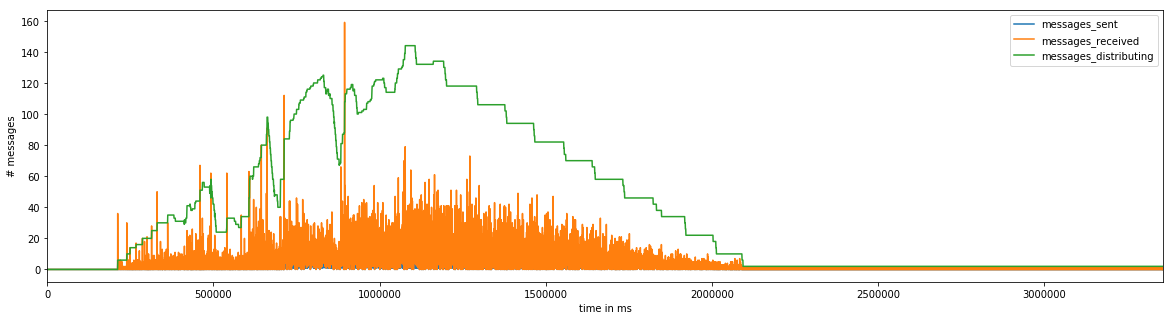

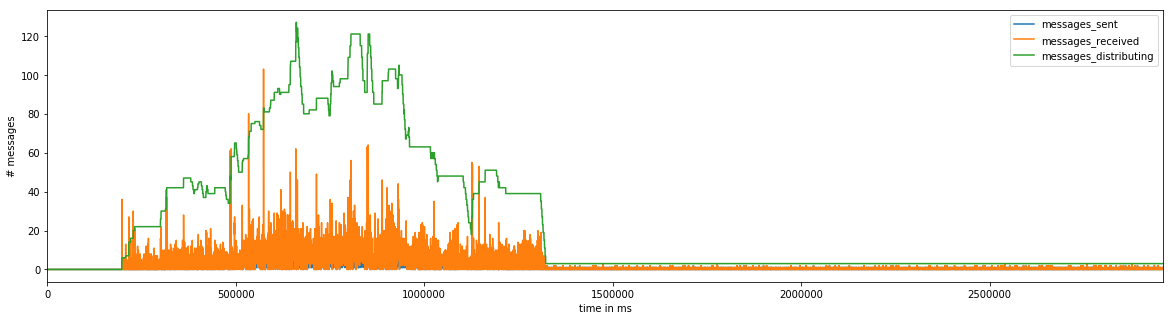

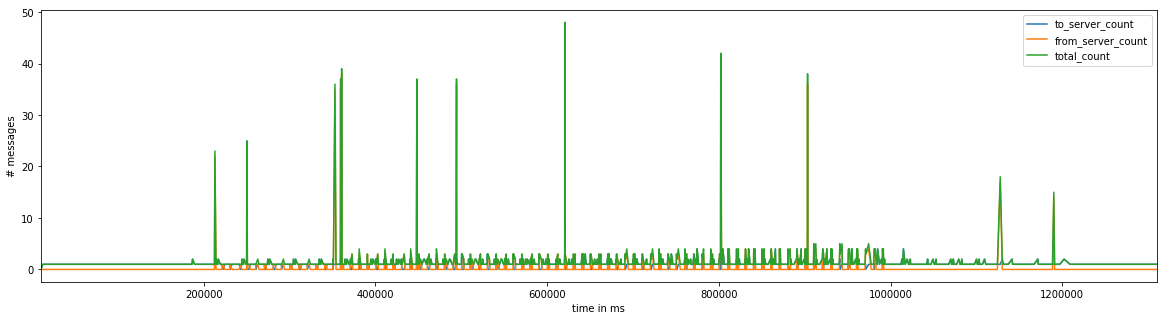

In [4]:
messages_over_time = {}
for key in ['NYSCrash', 'NYSCrashAutonomousNoBeacon']:
    messages_over_time[key] = data_messages[key][['simulation_time', 'messages_sent', 'messages_received', 'messages_distributing']] \
    .groupby('simulation_time') \
    .sum()
for key in ['NYSCrashCentralized']:
    messages_over_time[key] = data_messages[key] \
    .groupby('time') \
    .sum()

for key, df in messages_over_time.items():
    ax = df.plot()
    ax.set(xlabel='time in ms', ylabel='# messages')

To obtain a visually more telling plots, we apply Gaussian smoothing to our data:

NYSCrash
NYSCrashAutonomousNoBeacon
NYSCrashCentralized


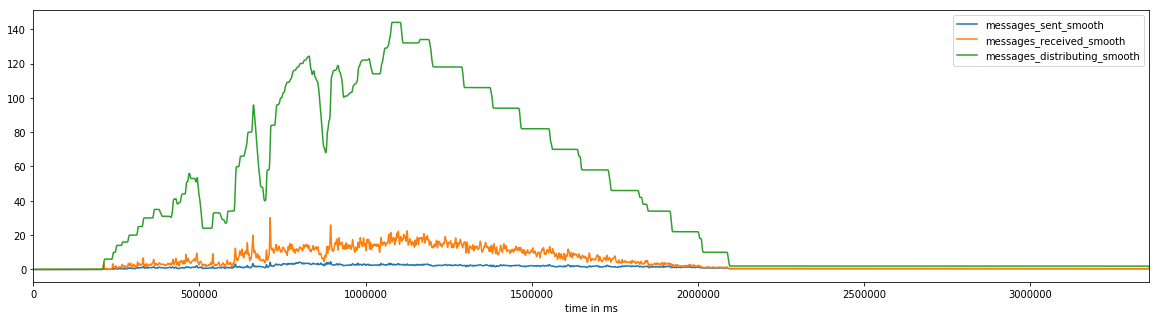

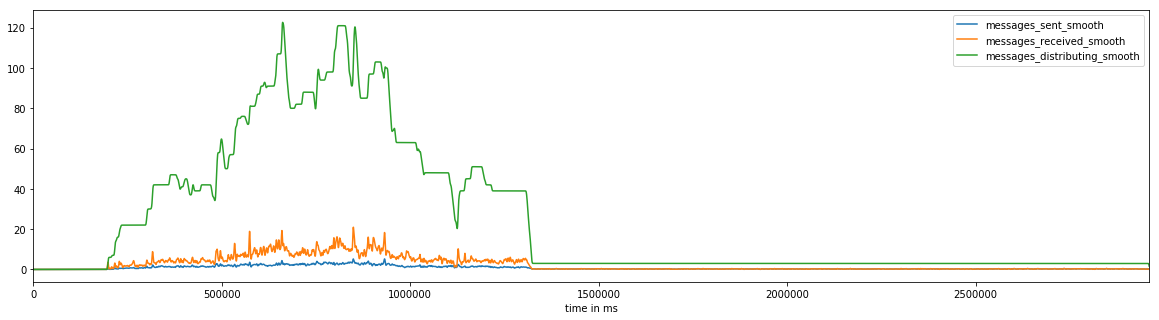

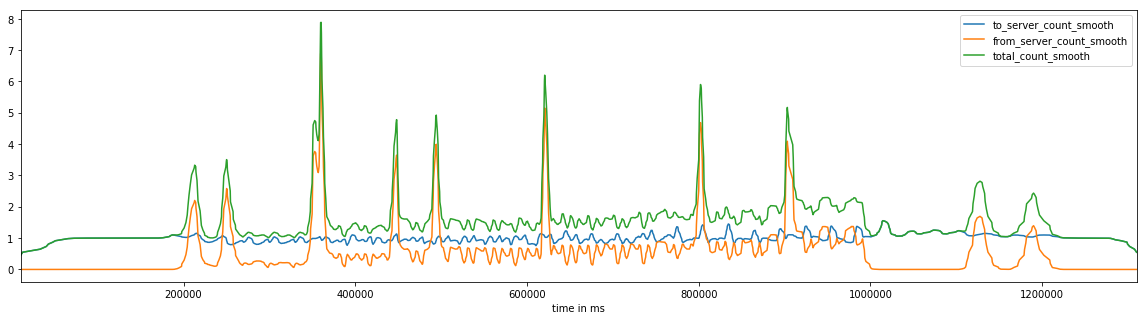

In [5]:
gaussian_kernel = Gaussian1DKernel(4)
for key, df in messages_over_time.items():
    for column in df:
        df[column + '_smooth'] = convolve(df[column].as_matrix(), gaussian_kernel)

for key in ['NYSCrash', 'NYSCrashAutonomousNoBeacon']:
    print("{0:}".format(key))
    ax = messages_over_time[key][['messages_sent_smooth', 'messages_received_smooth', 'messages_distributing_smooth']] \
        .plot()
    ax.set(xlabel='time in ms')
    
for key in ['NYSCrashCentralized']:
    print("{0:}".format(key))
    ax = messages_over_time[key][['to_server_count_smooth', 'from_server_count_smooth', 'total_count_smooth']] \
        .plot()
    ax.set(xlabel='time in ms')

A simple and suitable metric to compare the performance with respect to messsaging are `messages_sent` and `total_count`. The former, when aggregated over all actors in the simulation for each time-step, captures the **total number of messages being transmitted in the simulation** at a given time and the latter captures the **total number of messages being sent to the server** at a given time. Thus, both observables are good measures of the total message traffic in their respective simulation scenario. Since the number of messages being exchanged in a traffic situation is to be minimized, a low number of messages indicates a better scalability of the system.

Although the total number of messages in the simulation are within the same order of magnitude for all scenarios, the **fully centralized scenario has greater communication spikes** than the other two centralized scenarios.

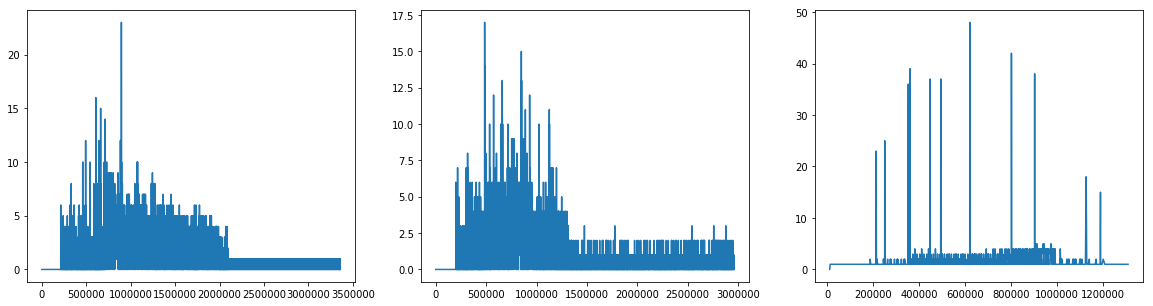

In [6]:
plt.subplot(1,3,1)
plt.plot(messages_over_time['NYSCrash']['messages_sent'])
plt.subplot(1,3,2)
plt.plot(messages_over_time['NYSCrashAutonomousNoBeacon']['messages_sent'])
plt.subplot(1,3,3)
plt.plot(messages_over_time['NYSCrashCentralized']['total_count'])

This result can be captured more succinctly by looking at the **average number of messages** at a given time (denoted $\mu(messageCount)$) and the corresponding **standard deviation** (denoted $\sigma(messageCount)$), where $messageCount$ is `messages_sent` in the decentralized scenarios and `total_count` in the centralized scenario. As we can see, the **fully centralized scenario outperforms the other scenarios with respect to both metrics**. The **fully centralized** scenario **performs worst with respect to all metrics**, thus making it the least stable of all scenarios. This is not a surprising result, since we assume that all traffic participants are informed about all traffic incidents, thus leading to more messages and to spikes in message exchange whenever an issue is detected.

[Text(0,0.5,'# messages'), Text(0.5,0,'scenario')]

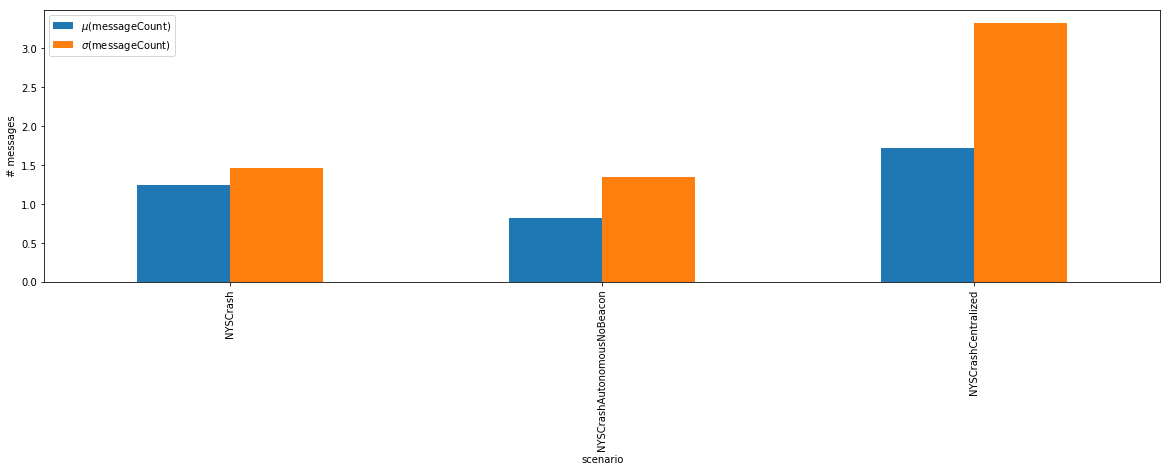

In [7]:
message_aggregates = {}
for key in ['NYSCrash', 'NYSCrashAutonomousNoBeacon']:
    message_aggregates[key] = messages_over_time[key][['messages_sent']] \
    .agg([np.mean, np.std]) \
    .rename(index=str, columns={'messages_sent': 'message_count'})
for key in ['NYSCrashCentralized']:
    message_aggregates[key] = messages_over_time[key][['total_count']] \
    .agg([np.mean, np.std]) \
    .rename(index=str, columns={'total_count': 'message_count'})

avg_count = [df['message_count']['mean'] for scenario, df in message_aggregates.items()]
std_count = [df['message_count']['std'] for scenario, df in message_aggregates.items()]

count_data = pd.DataFrame({
    r'$\mu$(messageCount)': avg_count,
    r'$\sigma$(messageCount)': std_count,
}, index=message_aggregates.keys())
ax = count_data.plot.bar()
ax.set(xlabel='scenario', ylabel='# messages')

This seems to indicate that even for small scenarios, decentralized models can be tuned to perform better with respect to communication than partly or fully centralized scenarios. In more complex scenarios, the advantages of decentralized scenarios with respect to centralized scenarios should become even more apparent (assuming the decentralized model does not lead to unexpected emerging behaviour), which is an encouraging result in favor of decentralized models.

---

## Traffic Analyis:

In this section we take a look at the results from our simulation regarding vehicle traffic. A straight-forward metric to determine how well a particular routing solution works in comparison to others is the **mean time of travel** (denoted $\mu(travelTime)$), as well as the **standard deviation of travel time** (denoted $\sigma(travelTime)$). We consider this to be a good metric since for traffic participants, minimizing travel time along with travel expense should be a key priority. 

Needless to say, for bad routing models, one can expect the mean travel time per vehicle to be higher than in good models. The standard deviation of travel time is also a good metric to determine routing quality, since it tells us how reliable  a routing approach is. If a routing model delivers sometimes blazing fast and other times painfully slow travel times, a traffic participant cannot be sure whether the routing model it follows is going to turn out beneficial and the incentive to collectively follow a certain model of routing will be low.

The results are as follows: The scenario with **fully decentralized** communication (`NYSCrashAutonomousNoBeacon`) **and** the one with **fully centralized** communication (`NYSCrashCentralized`) **perform almost equally well**, with the fully decentralized scenario performing slightly better in all metrics, while the **semi-centralized** scenario (`NYSCrash`) with beacons **performs worse** than the former two with respect to all metrics.

[Text(0,0.5,'time in ms'), Text(0.5,0,'scenario')]

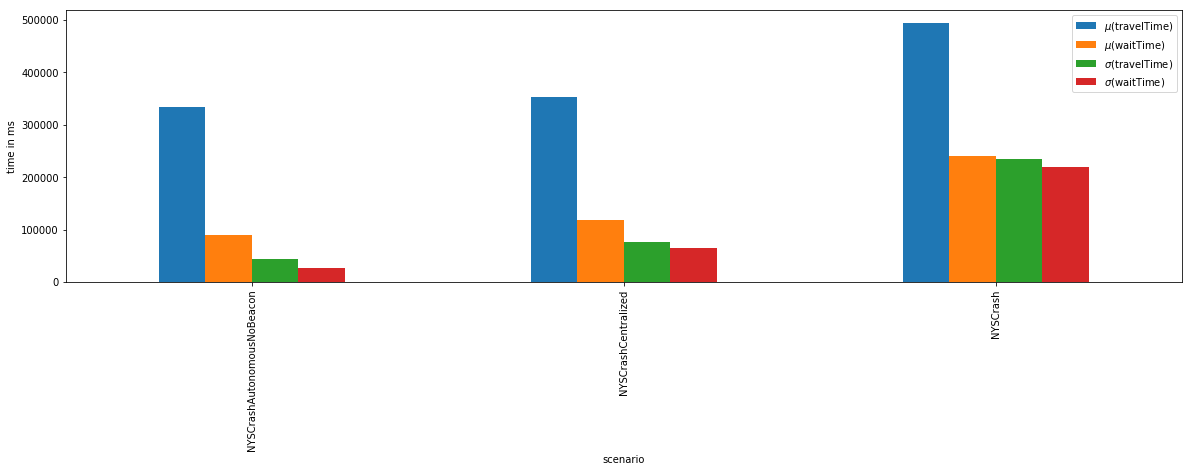

In [8]:
aggregates = {}
for key in data_vehicles.keys():
    aggregates[key] = data_vehicles[key][['id', 'wait_time', 'travel_time']] \
    .groupby('id') \
    .sum() \
    .agg([np.mean, np.std])
    
avg_tt = [df['travel_time']['mean'] for scenario, df in aggregates.items()]
avg_wt = [df['wait_time']['mean'] for scenario, df in aggregates.items()]
std_tt = [df['travel_time']['std'] for scenario, df in aggregates.items()]
std_wt = [df['wait_time']['std'] for scenario, df in aggregates.items()]

average_tt = pd.DataFrame({
    r'$\mu$(travelTime)': avg_tt,
    r'$\mu$(waitTime)': avg_wt,
    r'$\sigma$(travelTime)': std_tt,
    r'$\sigma$(waitTime)': std_wt
}, index=aggregates.keys())
ax = average_tt.plot.bar()
ax.set(xlabel='scenario', ylabel='time in ms')

We initially found this result to be confusing, since naively, one may expect that more communication means more information per traffic participant and thus better routing decisions. Therefore, the semi-centralized scenario could be expected to perform as well as the fully decentralized scenario. However, since our cars use fairly simple routing heuristics, too much information may actually lead to too much rerouting, which may negatively impact the metrics we used. Then again, this argument can also be applied to centralized communication which had a better performance.

We found the cause for the bad results in the semi-centralized scenario by monitoring the simulation: While calculating a new route, many vehicles end up in a long road with no possibility to perform a U-turn (see Image 3). While the vehicles do eventually detect the traffic jam, they cannot switch to a new route and the next beacon is too far away to propagate the message far enough backward to prevent other cars from entering the road, causing the cars to pile up in said road.

Two major points can be made about this observation: 1. Such a scenario could be prevented in real-life by installing more beacons or by extending the transmission range of vehicles themselves. 2. This scenario **could have also occurred in the fully decentralized** scenario, **but not in centralized scenario**.

<center>
    <img width=75% src="../../res/img/jam.png" />
    <br>
    Image 3: Traffic jam, detected by vehicles marked as blue.
</center>

It follows that the above results with respect to the metrics should be considered with critical care and that more exhaustive research  is required to obtain scientifically solid results. Nonetheless, the results are interesting, since they demonstrate that even for a scenario as simple as this one, decentralized routing without beacons can be more efficient than centralized routing with beacons if the latter are not optimally placed and as efficient as as centralized routing.

---
## Outlook:

Future work should focus on the simulation of **further and more complex scenarios** which should also contemplate **different simulation parameters** such as **communication range of vehicles and beacons** in order to obtain a more telling and resilient result on which model performs best, and under which circumstances.